#ENSIAS 2023
#Socila Network Analysis
#Sentiment Analysis using BERT Darija 
we will try in this notebook to use the data we have already collected in our (souk de entrepreneurs) group
in ordre to predict the sentiments of commenters on the post (positive,negative or neutral)

BERT (Bidirectionnal Encoder Representations for Transformers) is a “new method of pre-training language representations” developed by Google and released in late 2018.

### Import Libraries and Set the intial variables

In [1]:
!pip install transformers googletrans==3.1.0a0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 85.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 54.7 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16368 sha256=a05b411b11a8fcfa316c48e04c579264b0a4aee4aa35

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import googletrans
from googletrans import Translator
# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from tqdm import *
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
# Misc.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'
# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the data

In [4]:
df = pd.read_csv('Sentiment_Anaysis.csv')
df.shape

(52210, 3)

In [5]:
conditions = [df['label'].eq('pos'),df['label'].eq('neu'),df['label'].eq('neg')]
choices = [2,1,0]
df['sentiment'] = np.select(conditions, choices, default=0)
df.head()

,Unnamed: 0,Twits,label,sentiment
0,0,what happens,neu,1
1,1,😞😞,neg,0
2,2,ان شاء الله,neu,1
3,3,بالتوفيق ان شاء الله,pos,2
4,4,الحمدلله على كل حال,pos,2
5,5,الله يستر,neu,1
6,6,امين,neu,1
7,7,شكرا لك,pos,2
8,8,ههههههههه,pos,2
9,9,"هههه ضروري بإذن الله , لفقر را عيب ؤ عار ؤ حشومة",neg,0


We can see that the most relevant column for us is content and replyContent and the score as well.

In [6]:
# Let's check for missing values 
df.isnull().sum()

Unnamed: 0    0
Twits         0
label         0
sentiment     0
dtype: int64

We can see that we have more positive classes than negative and low number of neutral class. I have kept neutral less to focus more on positive and negative classes. Let's allot classes based on scores now. 

* 0 - negative
* 1 - neutral 
* 2 - positive

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

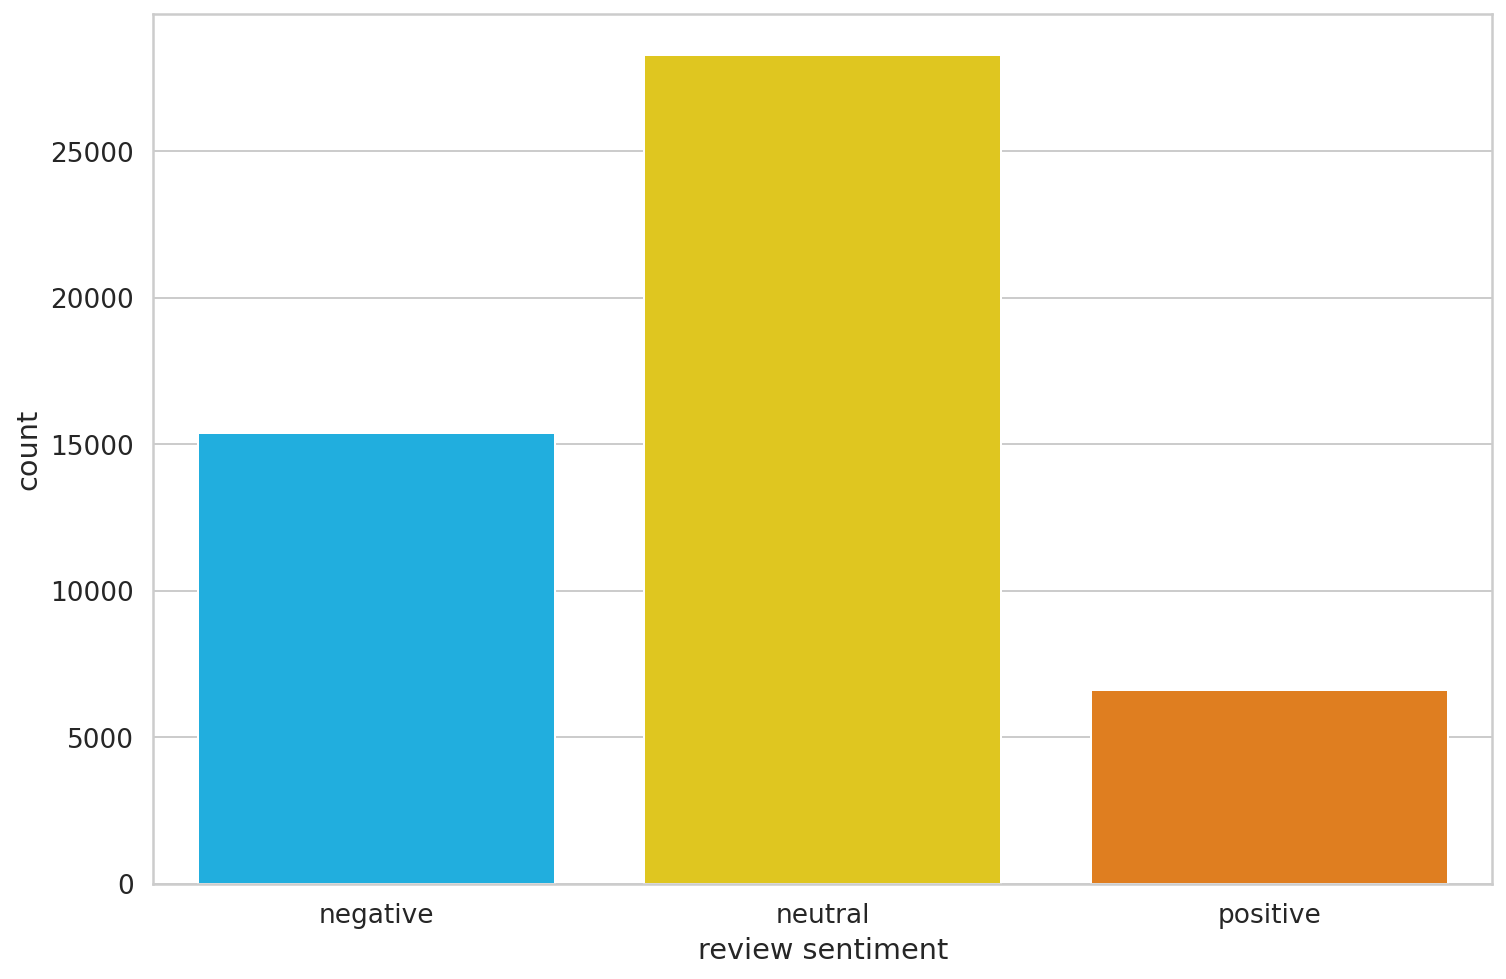

In [40]:
# Plot the distribution
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

## Data Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation. 

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.  

The tokenizer will break the sentence into words and give numerical values to each word. 

In [9]:
# Set the model name
# MODEL_NAME = 'bert-base-cased'
# MODEL_NAME ='aubmindlab/bert-base-arabertv02'
MODEL_NAME='SI2M-Lab/DarijaBERT'
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("SI2M-Lab/DarijaBERT")
bert_model = AutoModel.from_pretrained("SI2M-Lab/DarijaBERT")
# Build a BERT based tokenizer
# tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/307 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Downloading:   0%|          | 0.00/879k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Downloading:   0%|          | 0.00/836M [00:00<?, ?B/s]

Some weights of the model checkpoint at SI2M-Lab/DarijaBERT were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You

In [10]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 3
[CLS] 2
[PAD] 0
[UNK] 1


In [11]:
import re
import string
# ''''`÷×؛ç<>_()*&^%][ـ،/:"؟.,'{}~ ⃣¦+éèûà([@A-Za-z0-9_]+)|[^\w\s]|#|http\S+\n0123456789''''
arabic_punctuations = '''`•²÷×؛’ôâêâ«»<>()*&^%]î€[ـ،/:"؟.,|!”…“–ـ﷿🤔'{}~¦œ+|!”…“–ـ🤔éèûà([@A-Za-z0-9_]+)|[^\w\s]|#|http\S+\n0123456789'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
emojis = re.compile(pattern = "["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"  
                           "]+", flags = re.UNICODE)


def all_pre(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("_"," ", text)
    text = re.sub("گ", "ك", text)
    text = re.sub(r'[a-z]','', text.lower())
    text = re.sub(arabic_diacritics, '', text)
    # text = re.sub(r'(.)\1+', r'\1', text)
    translator = str.maketrans('', '', punctuations_list)
    text = text.translate(translator)
    text = emojis.sub(r'',text)
    return text
    

In [25]:
for i,row in df.iterrows():
  # print(any(c.isalpha() for c in df['Twits'][i]))
  if re.search('[a-zA-Z]', df['Twits'][i])!=None:
    translator = Translator()
    translated = translator.translate(row['Twits'], dest='arabic')
    # print(df['Twits'][i])

ماعندك علاه تخافي مادام مش انت اللي مصورتوا حرروا المعتقلين          توقفوا عن استدعاء النشطاء تروح كورونا زيدو انتوما
 مايشوفش ردودي تشوفوني انتم برك نورمالمون علخاطر حسابي خاص عاملتوا حرروا المعتقلين          توقفوا عن استدعاء النشطاء تروح كورونا زيدو انتوما
 بعد ان اثارت الجدل في مسوده الدستور المءسسه العسكريه توضح اسباب ادراج ماده السماح بارسال قوات من الجيش خارج الحدود 
 تقرير  عن القشابيه الجزاءريه لا لسرقه التراث الجزاءري
الله يسلمك وانتم زاده حرروا المعتقلين          توقفوا عن استدعاء النشطاء تروح كورونا زيدو انتوما
الحراك المخترق تم اختراقه مره ثانيه  وهكذا هي سنه الله كما تدين تدان رشاد  العلمانيه
الجيش عارف خدمته مش احنا اللي نعتو له واش يدير  اكيد تركت المنطقه لتكون عسكريه لحراس الحدود و مش باغيين فيها سكان او مدنيين ليسهل الحمايه و التصدي لمن يخترق الحدود مش فاهمه هل انتم تتهمو الجيش انه تنازل عن كيلو مترات من ارضنا لمالي او ماذا جيشنا فخرنا
ايدير وري الثري بعد ظهر اليوم الاربعاء بمقبره الاب بفرنسا
 هدفنا واحد يتنحاو ڨاع   
شركه شحن مثل الشركات العالميه 
توقفوا عن استدعاء 

In [26]:
for i,row in df.iterrows():
    df['Twits'][i]=all_pre(row['Twits'])
display(df)    


,Unnamed: 0,Twits,label,sentiment
0,0,ماذا حدث,neu,1
1,1,,neg,0
2,2,ان شاء الله,neu,1
3,3,بالتوفيق ان شاء الله,pos,2
4,4,الحمدلله علي كل حال,pos,2
...,...,...,...,...
52205,52205,هاي باهي وليت تفهم في اللبسه متاع الرجال,neu,1
52206,52206,ريي يصبر امها,neu,1
52207,52207,اللهم امين يارب العالمين ربي يصبر اهلهم,pos,2
52208,52208,اللهم امين يارب العالمين مخيبها عواشر لا حول و...,pos,2


In [35]:
display(df)
for i ,row in df.iterrows():
  if not any(c.isalpha() for c in df['Twits'][i]):
    df=df.drop(i)
df.reset_index(inplace=True,drop=True)
display(df)

,Unnamed: 0,Twits,label,sentiment
0,0,ماذا حدث,neu,1
2,2,ان شاء الله,neu,1
3,3,بالتوفيق ان شاء الله,pos,2
4,4,الحمدلله علي كل حال,pos,2
5,5,الله يستر,neu,1
...,...,...,...,...
52205,52205,هاي باهي وليت تفهم في اللبسه متاع الرجال,neu,1
52206,52206,ريي يصبر امها,neu,1
52207,52207,اللهم امين يارب العالمين ربي يصبر اهلهم,pos,2
52208,52208,اللهم امين يارب العالمين مخيبها عواشر لا حول و...,pos,2


,Unnamed: 0,Twits,label,sentiment
0,0,ماذا حدث,neu,1
1,2,ان شاء الله,neu,1
2,3,بالتوفيق ان شاء الله,pos,2
3,4,الحمدلله علي كل حال,pos,2
4,5,الله يستر,neu,1
...,...,...,...,...
50261,52205,هاي باهي وليت تفهم في اللبسه متاع الرجال,neu,1
50262,52206,ريي يصبر امها,neu,1
50263,52207,اللهم امين يارب العالمين ربي يصبر اهلهم,pos,2
50264,52208,اللهم امين يارب العالمين مخيبها عواشر لا حول و...,pos,2


In [91]:
# df.replace(' ', np.nan, inplace=True)
# df.replace('', np.nan, inplace=True)
# df.dropna(inplace=True)
# df.reset_index(inplace=True,drop=True)
# df.drop('Unnamed: 0',axis=1,inplace=True)
display(df)
df.to_json('predarija.json')

,Twits,label,sentiment,prediction
0,ماذا حدث,neu,1,0
1,ان شاء الله,neu,1,0
2,بالتوفيق ان شاء الله,pos,2,0
3,الحمدلله علي كل حال,pos,2,0
4,الله يستر,neu,1,0
...,...,...,...,...
50261,هاي باهي وليت تفهم في اللبسه متاع الرجال,neu,1,0
50262,ريي يصبر امها,neu,1,0
50263,اللهم امين يارب العالمين ربي يصبر اهلهم,pos,2,0
50264,اللهم امين يارب العالمين مخيبها عواشر لا حول و...,pos,2,0


In [ ]:
df=pd.read_json('predarija.json')
display(df)

In [37]:
# Store length of each review 
token_lens = []
# Iterate through the content slide
for txt in df.Twits:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

Text(0.5, 0, 'Token count')

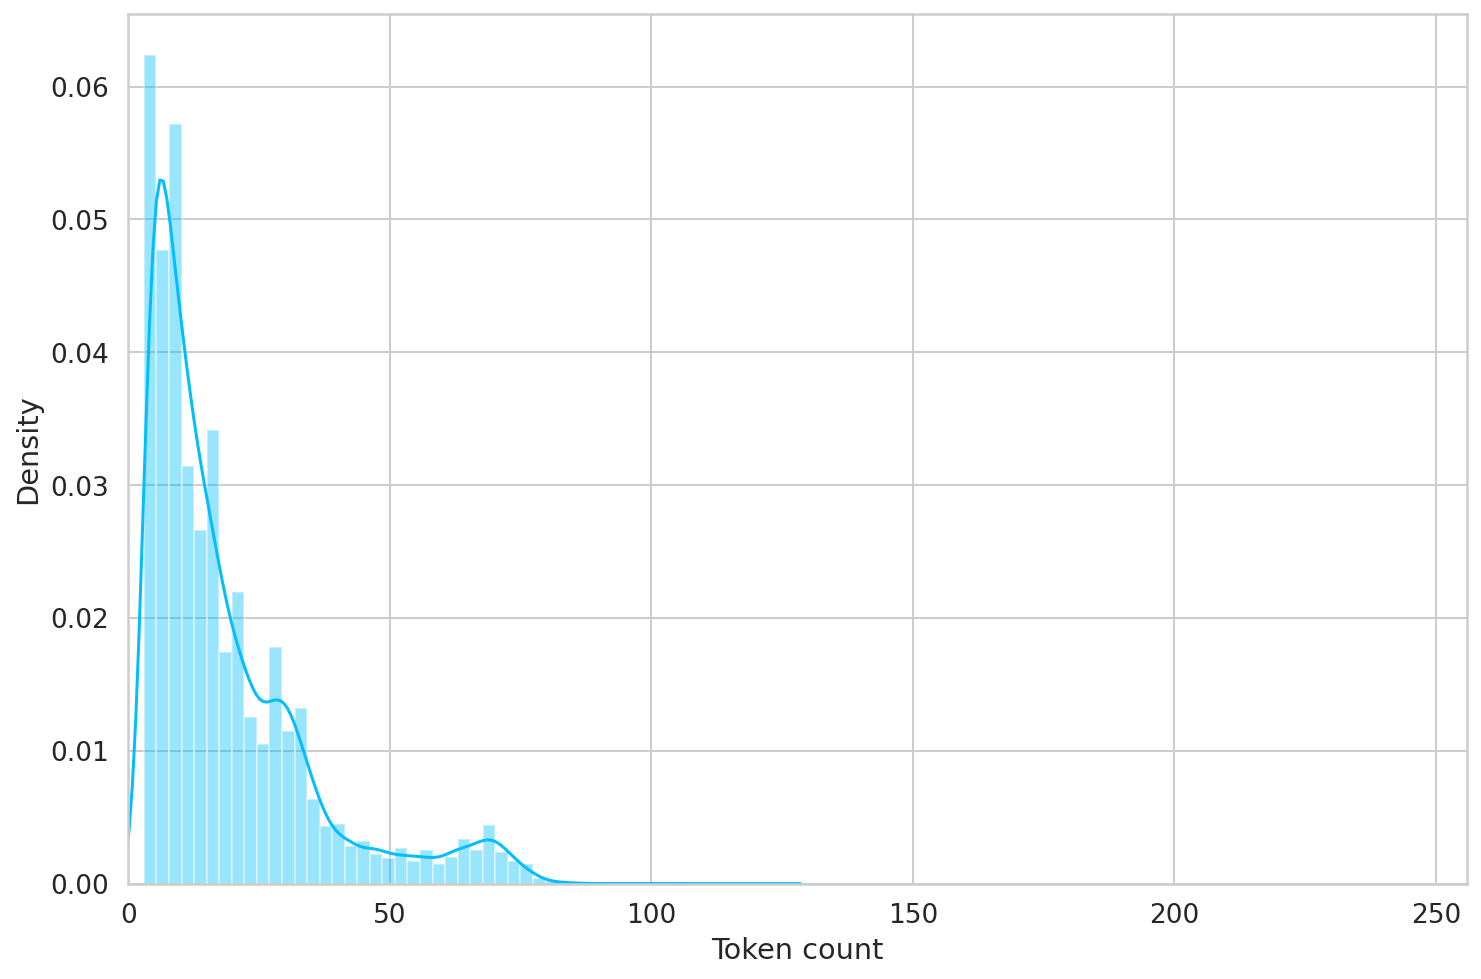

In [38]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

Most of the reviews seem to contain less than 120 tokens, but we’ll be on the safe side and choose a maximum length of 160. 

In [39]:
MAX_LEN = 90

### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily. 

In [41]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

**Create** a 90% train data and 5% test and 5% validation data

In [42]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(45239, 3) (2513, 3) (2514, 3)


Create a dataloader to release data in batches.

In [43]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.Twits.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [44]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [45]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 90])
torch.Size([16, 90])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [46]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)
# bert_model = AutoModel.from_pretrained("SI2M-Lab/DarijaBERT")


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some weights of the model checkpoint at SI2M-Lab/DarijaBERT were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not 

In [47]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        # self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask ,return_dict=False):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [48]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some weights of the model checkpoint at SI2M-Lab/DarijaBERT were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not 

#### Model Characterstics

In [49]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [50]:
# Number of iterations 
EPOCHS = 1

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [51]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

Write a function to evaluate model performance

In [52]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                return_dict=False
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

Write the training Loop and store the best training state.

In [53]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    # if val_acc > best_accuracy:
    #     torch.save(model.state_dict(), 'best_model_state.bin')
    #     best_accuracy = val_acc 

Epoch 1/1
----------


100%|██████████| 2828/2828 [12:45<00:00,  3.69it/s]


Train loss 0.45291215747784525 accuracy 0.8271624041203386
Val   loss 0.4415730420806551 accuracy 0.83008356545961

CPU times: user 8min 49s, sys: 3min 57s, total: 12min 47s
Wall time: 13min


The above took a lot of time but it's finally working. Now, we can plot the training and validation accuracy.

### Model Evaluation

In [87]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8488464598249802

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [88]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [89]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [78]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.86      0.84      0.85       768
     neutral       0.86      0.91      0.89      1428
    positive       0.73      0.58      0.65       318

    accuracy                           0.85      2514
   macro avg       0.82      0.78      0.80      2514
weighted avg       0.85      0.85      0.85      2514



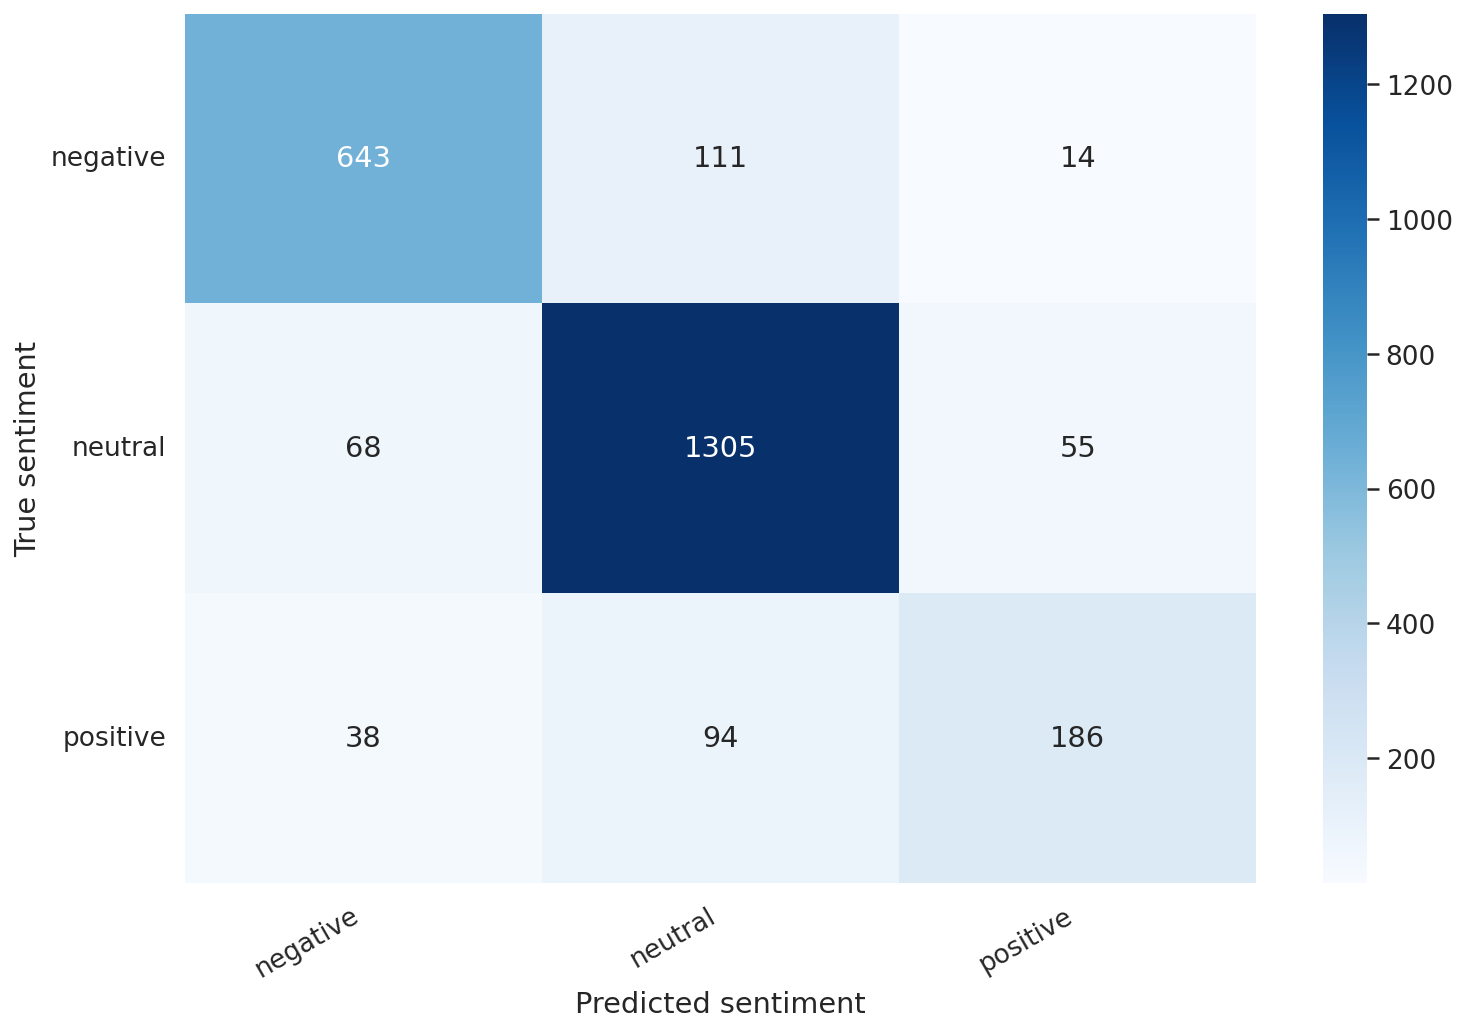

In [60]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model.

## Predicting on raw text

In [65]:
import googletrans
from googletrans import Translator

df1=pd.read_json('data.json')
df1=pd.DataFrame(df1['post_text'])
for i ,row in df1.iterrows():
  translator = Translator()
  translated = translator.translate(row['post_text'], dest='arabic')
  df1['post_text'][i]=translated.text
for i ,row in df1.iterrows():
  
  df1['post_text'][i]=all_pre((row['post_text']))
#   print(tokenizer.convert_ids_to_tokens(tokenizer.encode(df['post_text'][i])))
# df.replace(' ', np.nan, inplace=True)
# df.replace('', np.nan, inplace=True)
# df.dropna(inplace=True)
# df.reset_index(inplace=True,drop=True)
display(df1)

,post_text
0,اول حاجه كنبغي نقول سنه سعيده لي كملت السنه...
1,لي عنده شي زهر مشروع المشروعالمهم جربو زهركمال...
2,الحاضنه الافريقيه الفرنكوفونيه حديث ملهم رقم ...
3,المقاوله الاجتماعيه واحد المفهوم قليل لي تيعرف...
4,البريد بنك ينظم دورات تكوينيه مجانيه لفاءده ال...
...,...
415,عندما تود التفكير في اخذ مشروعك الي العالميه ...
416,بدء التشغيل الافريقيتطوير حلول مبتكره لتقريب م...
417,‏شركه مطاعم تبيع رخص فرنشايزالفروع الممنوحه تح...
418,الناس ديال جهه مراكش اسفيلمساعدتك في بناء مشرو...


In [67]:
df1['prediction']=0
for i , row in df1.iterrows():
  review_text=row['post_text']
  encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',)
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  df1['prediction'][i]=class_names[prediction]

# print(f'Review text: {review_text}')
# print(f'Sentiment  : {class_names[prediction]}')
# review_text = "شكون غادي يجاوب علي هذا السءال"

In [68]:
display(df1)

,post_text,prediction
0,اول حاجه كنبغي نقول سنه سعيده لي كملت السنه...,negative
1,لي عنده شي زهر مشروع المشروعالمهم جربو زهركمال...,negative
2,الحاضنه الافريقيه الفرنكوفونيه حديث ملهم رقم ...,neutral
3,المقاوله الاجتماعيه واحد المفهوم قليل لي تيعرف...,negative
4,البريد بنك ينظم دورات تكوينيه مجانيه لفاءده ال...,negative
...,...,...
415,عندما تود التفكير في اخذ مشروعك الي العالميه ...,negative
416,بدء التشغيل الافريقيتطوير حلول مبتكره لتقريب م...,negative
417,‏شركه مطاعم تبيع رخص فرنشايزالفروع الممنوحه تح...,negative
418,الناس ديال جهه مراكش اسفيلمساعدتك في بناء مشرو...,negative


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

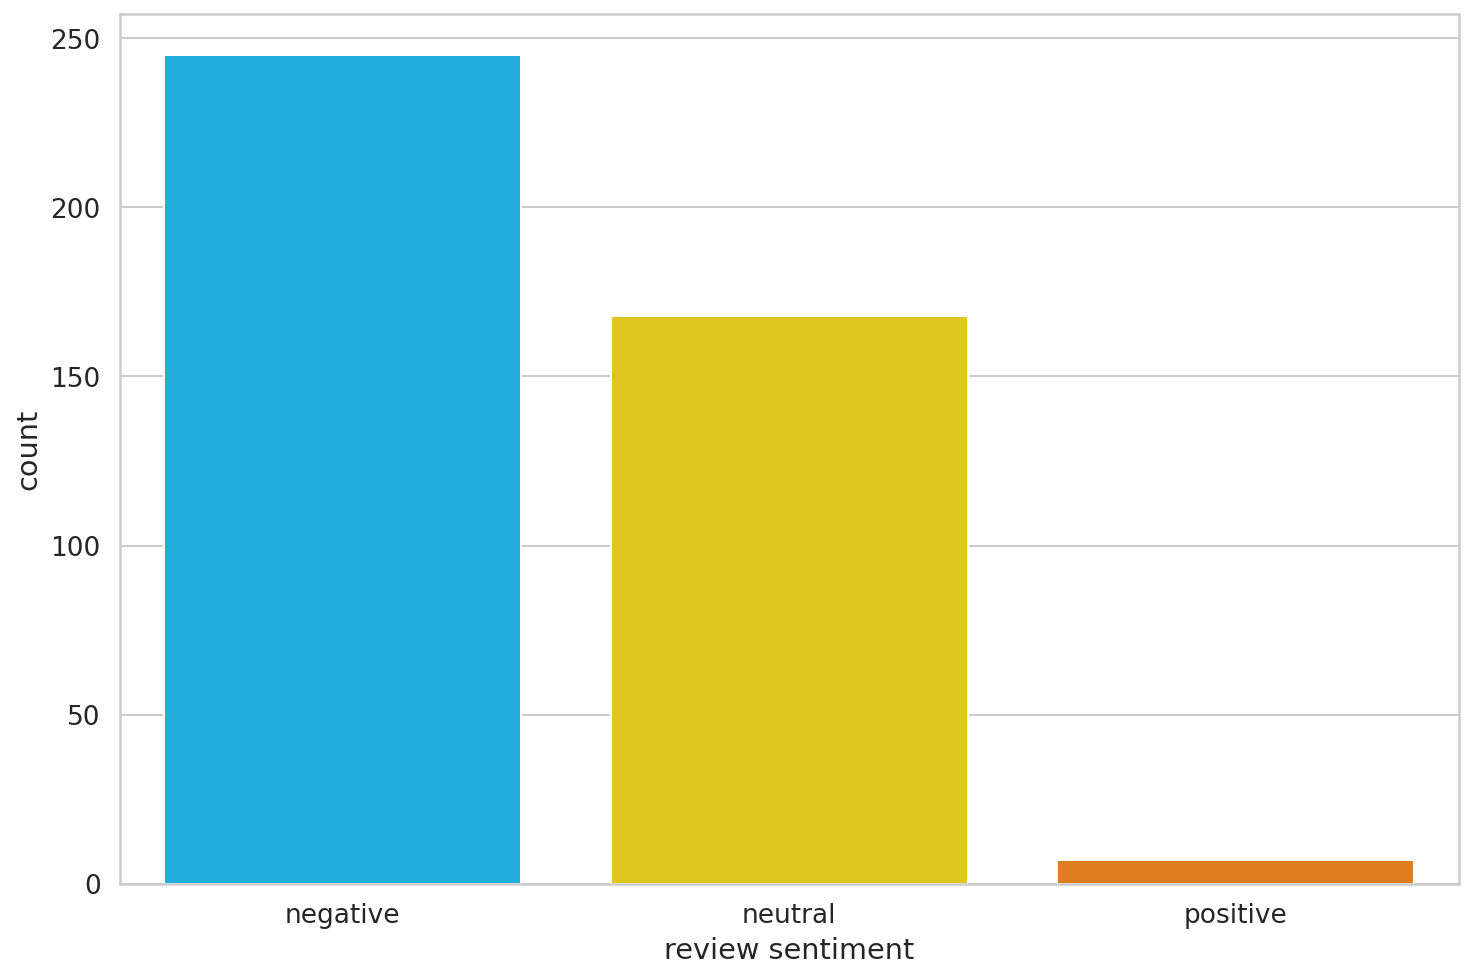

In [70]:
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df1.prediction)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

In [72]:
for i ,r in df1.iterrows():
  if r['prediction']=='negative':
    print(r['post_text'])
    print(i)

اول حاجه كنبغي نقول سنه سعيده    لي كملت السنه الخامسه ديالهاو كنقول برافو   علي المجهودات لي تيديرها وعلي  و كنشكر الفريق كامل ديال    علي ايدوكان لي كانت فكرتها متميزه و شكر خاص لاختي    علي كلشيفي الاخير نبغي نبارطاجي معكم واحد المنصه جديده لي تقوم برقمنه سير وعمل تنظيم جواءز و برامج الاحتضان و التسريع و الاستثمارات و التعاون بين  و 
0
لي عنده شي زهر مشروع المشروعالمهم جربو زهركمالعرض المباشرسالتقي بك غدا الثلاثاء  يناير من الساعه  مساء لحضور جلسه مباشره علي تعال وقدم عرضا لمشروعك او شركتك او فكرتك  وساخبرك بما اعتقدهاعطيك النصيحهكيفيه المشاركه  عبر حساب  الخاص بيارسم من المشاركين كما ومتي  علي الهواء مباشرههل انت مستعد 
1
المقاوله الاجتماعيه واحد المفهوم قليل لي تيعرفو في الشعب المغربي العظيمالمقاوله الاجتماعيه بواسطتها تم حل بطريقه مستدامه و فيها  بزاف المشاكل لي تايعانيو منها الشعوب عبر العالمالبارح قلبت في واحد الموقع شاركه معنا   في واحد الدوره تكوينيه و دخلت قلبت فيه علي علي احسن دول ممكن دير فيها المقاوله الاجتماعيه  في التقرير ما لقيتش المغرب مصنف في   و لي صدمني كاينين دول 